Set up environment and load in data

In [1]:
library(tidyverse)
library(here)
library(grid)
library(gridExtra)
theme_set(theme_bw())
helpers_path = paste0(here(),'/analysis/helpers/')
source(paste0(helpers_path, '01_clean_behavioral_data.R'))
rm(data_bc_clean)
fig_out_path = paste0(here(), '/outputs/fig/')

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
here() starts at /Users/zenkavi/Documents/RangelLab/NovelVsRepeated/behavior


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




[1] "Done loading data."
[1] "Resetting helpers path..."


**Make sure to scale value and exclude too fast trials before fitting**

In [2]:
normMax = 1
normMin = -1

data_yn_clean = data_yn_clean %>%
  filter(reference != -99) %>%
  filter(rt > .3 & rt < 5) %>% # discard very long and short RT trials
  group_by(subnum, day, type) %>%
  mutate(possiblePayoff_dmn = possiblePayoff - mean(possiblePayoff)) %>%
  mutate(rawVDiff = possiblePayoff - reference,
         normVDiff =  (normMax - normMin) / (max(rawVDiff) - min(rawVDiff)) * (rawVDiff - max(rawVDiff)) + (normMax) )

rm(normMax, normMin)

# Exploring priors and parameter space

What does a subject prior for drift rates look like in the HDDM (from Lombardi-Hare toolbox)

```
d.mu ~ dunif(.00001, 50)
d.pr ~ dgamma(1, .1)
d[subject] ~ dnorm(d.mu, d.pr) [trimmed at 10e-5, 50]

```

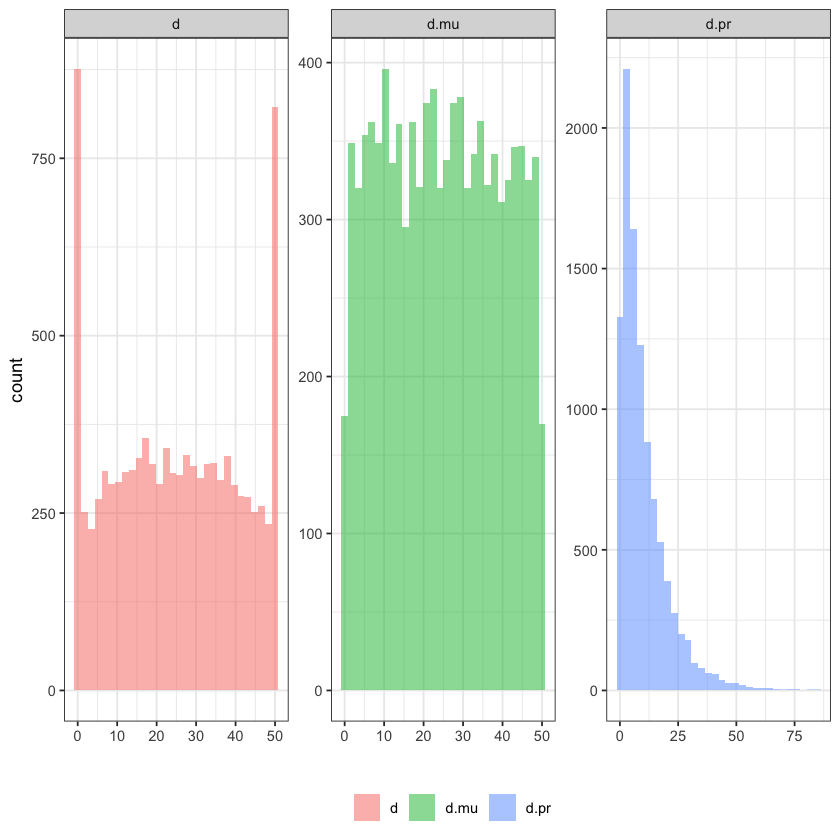

In [3]:
n = 10000

dat = data.frame(d.mu = runif(n, .00001, 50), d.pr = rgamma(n, 1, .1))

for(i in 1:nrow(dat)){
  dat$d[i] = rnorm(1, dat$d.mu[i], dat$d.pr[i])
}

dat$d = ifelse(dat$d > 50, 50, ifelse(dat$d<.000001, .000001, dat$d))

dat %>%
  # select(d) %>%
  gather(key, value) %>%
  # mutate(key = factor(key, levels = c("d.pr", "d.mu", "d"))) %>%
  ggplot(aes(value, fill=key))+
  geom_histogram(position = "identity", alpha = .5, bins = 30)+
  facet_wrap(~key, scales = "free")+
  theme(legend.position = "bottom")+
  labs(fill="", x="")

What about the bias and ndt? Uniform-ish too.

```
bias[p] ~ dbeta(bias.alpha, bias.beta)T(0.01,0.99)

bias.alpha <- bias.mu * bias.kappa
bias.beta <- (1 - bias.mu) * bias.kappa
bias.mu ~ dbeta(2, 2)T(0.01,0.99)
bias.kappa ~ dgamma(1, 0.5)
```

**NOTE: This is operationalized in the HDDM, ranging from 0 to 1 and no bias is .5**

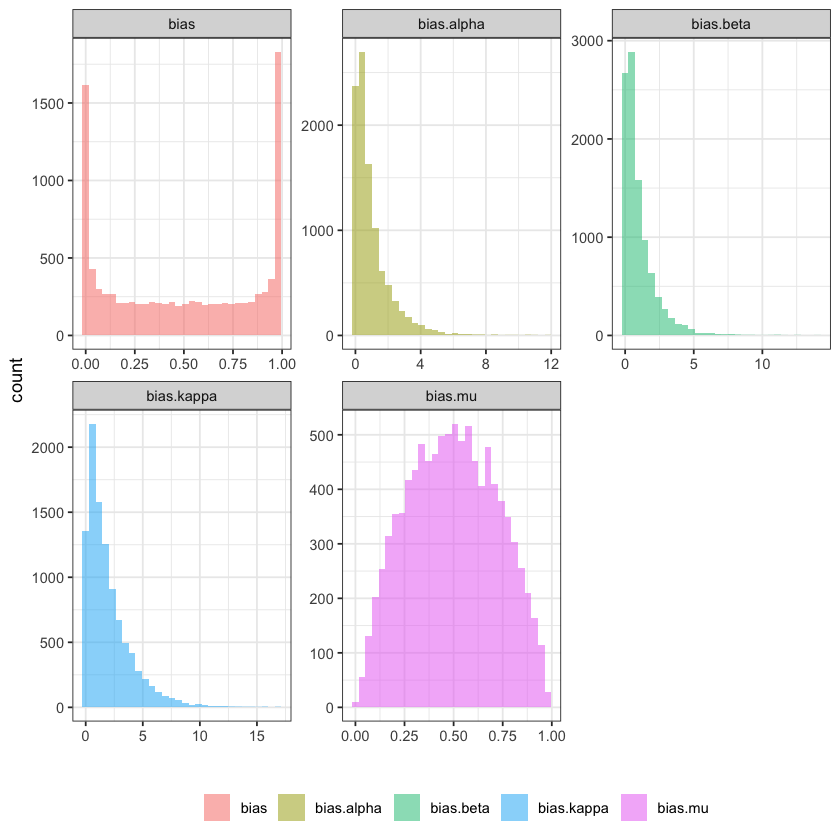

In [4]:
n = 10000

dat = data.frame(bias.kappa = rgamma(n, 1, .5), bias.mu = rbeta(n, 2, 2))

dat$bias.mu = ifelse(dat$bias.mu < .01, .01, ifelse(dat$bias.mu > .99, .99, dat$bias.mu))

dat = dat %>%
  mutate(bias.beta = (1 - bias.mu) * bias.kappa,
         bias.alpha = bias.mu * bias.kappa)

for(i in 1:nrow(dat)){
  dat$bias[i] = rbeta(1, dat$bias.alpha[i], dat$bias.beta[i])
}

dat$bias = ifelse(dat$bias < .01, .01, ifelse(dat$bias > .99, .99, dat$bias))

dat %>%
  gather(key, value) %>%
  ggplot(aes(value, fill=key))+
  geom_histogram(position = "identity", alpha = .5, bins = 30)+
  facet_wrap(~key, scales = "free")+
  theme(legend.position = "bottom")+
  labs(fill="", x="")


```
theta.p[p] ~ dnorm(ndt.mu, ndt.pr)T(0.01, 1)
ndt.pr ~ dgamma(1, 0.1)
ndt.mu ~ dunif(0, 1)
```

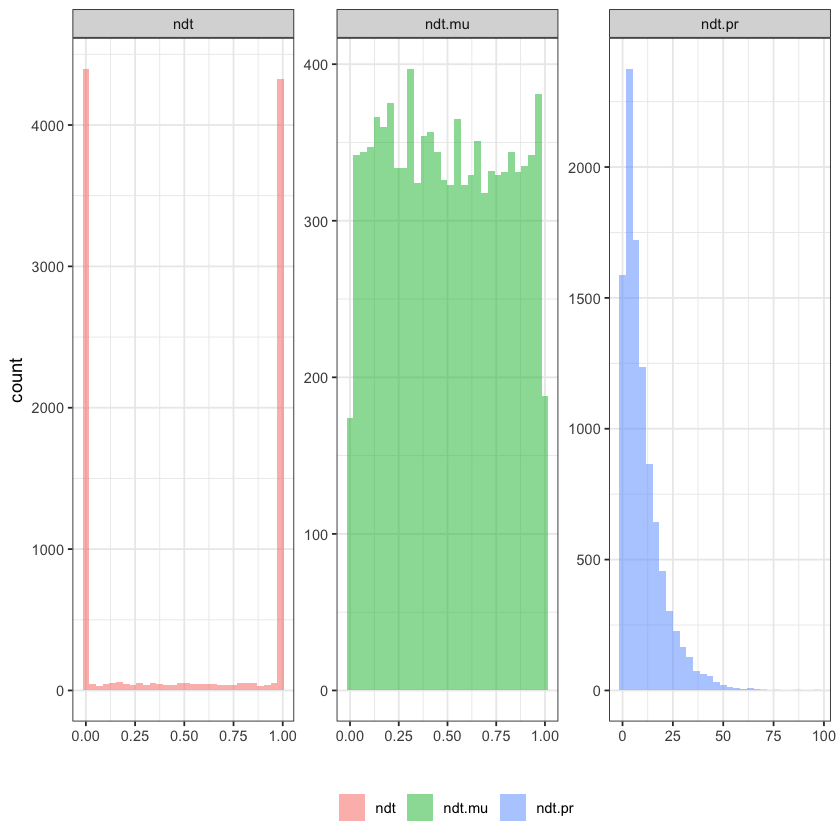

In [5]:
n = 10000

dat = data.frame(ndt.mu = runif(n, 0, 1), ndt.pr = rgamma(n, 1, .1))

for(i in 1:nrow(dat)){
  dat$ndt[i] = rnorm(1, dat$ndt.mu[i], dat$ndt.pr[i])
}

dat$ndt = ifelse(dat$ndt < .01, .01, ifelse(dat$ndt > 1, 1, dat$ndt))

dat %>%
  gather(key, value) %>%
  ggplot(aes(value, fill=key))+
  geom_histogram(position = "identity", alpha = .5, bins = 30)+
  facet_wrap(~key, scales = "free")+
  theme(legend.position = "bottom")+
  labs(fill="", x="")


What are reasonable values for barrierDecay? Prior: Uniform[0, .01]; min = 0, max = 0.02

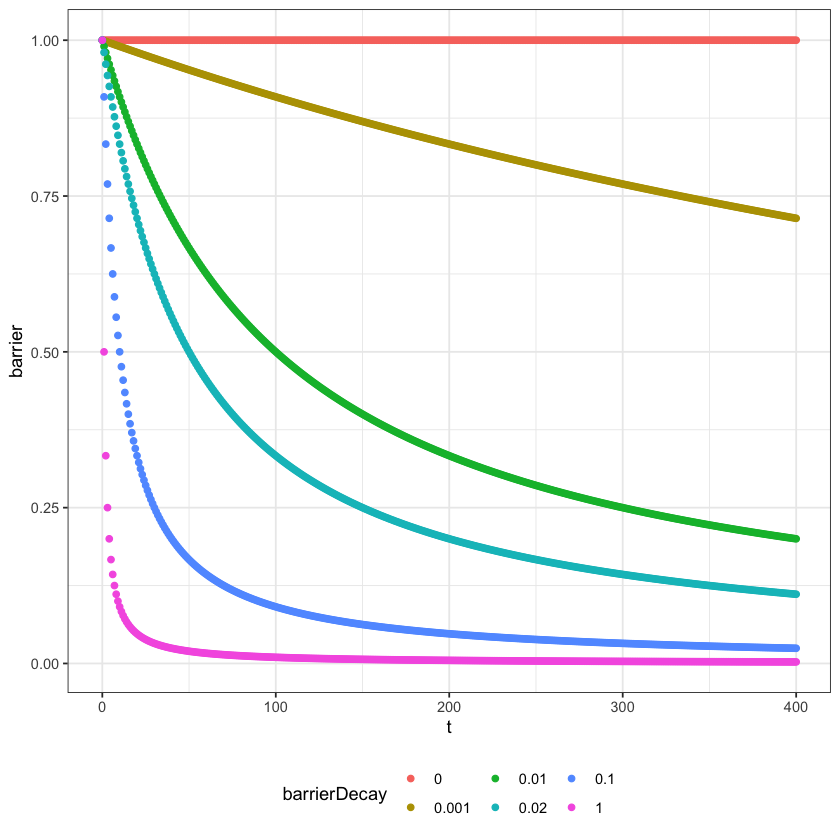

In [6]:
decay_vals = c(0, .001, .01, .02, .1, 1)

maxIter = 400

dat = data.frame()

for(cur_dv in decay_vals){
  cur_dat = data.frame(t = c(0:maxIter),
                       initialBarrier = 1, 
                       barrierDecay = cur_dv)
  
  cur_dat = cur_dat %>%
    mutate(barrier = initialBarrier / (1 + (barrierDecay * t)))
  
  dat = rbind(dat, cur_dat)
}

dat %>%
  mutate(barrierDecay = factor(barrierDecay, levels = decay_vals)) %>%
  ggplot(aes(t, barrier, color = barrierDecay))+
  geom_point()+
  theme_bw()+
  theme(legend.position = "bottom")

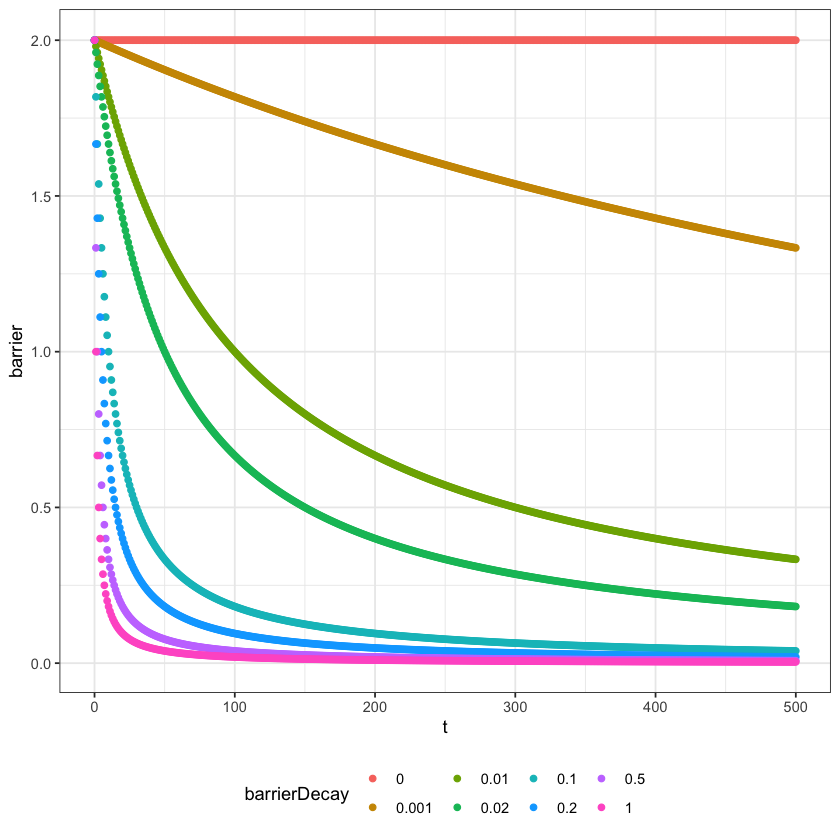

In [7]:
decay_vals = c(0, .001, .01, .02, .1, .2, .5, 1)

maxIter = 500

dat = data.frame()

for(cur_dv in decay_vals){
  cur_dat = data.frame(t = c(0:maxIter),
                       initialBarrier = 2, 
                       barrierDecay = cur_dv)
  
  cur_dat = cur_dat %>%
    mutate(barrier = initialBarrier / (1 + (barrierDecay * t)))
  
  dat = rbind(dat, cur_dat)
}

dat %>%
  mutate(barrierDecay = factor(barrierDecay, levels = decay_vals)) %>%
  ggplot(aes(t, barrier, color = barrierDecay))+
  geom_point()+
  theme_bw()+
  theme(legend.position = "bottom")

In [8]:
dat %>%
  filter(barrierDecay == .5) %>%
  arrange(-t)

t,initialBarrier,barrierDecay,barrier
<int>,<dbl>,<dbl>,<dbl>
500,2,0.5,0.007968127
499,2,0.5,0.007984032
498,2,0.5,0.008000000
497,2,0.5,0.008016032
496,2,0.5,0.008032129
495,2,0.5,0.008048290
494,2,0.5,0.008064516
493,2,0.5,0.008080808
492,2,0.5,0.008097166


In [ ]:
n = 10000

dat = data.frame(decay.alpha = rbeta(n, .1, 1), decay.beta = rgamma(n, 2, .5))
dat$decay.alpha = ifelse(dat$decay.alpha < 0, 0, ifelse(dat$decay.alpha > .5, .5, dat$decay.alpha))

for(i in 1:nrow(dat)){
  dat$decay[i] = rbeta(1, dat$decay.alpha[i], dat$decay.beta[i])
}

dat$decay = ifelse(dat$decay < 0, 0, ifelse(dat$decay > .5, .5, dat$decay))

dat %>%
  gather(key, value) %>%
  ggplot(aes(value, fill=key))+
  geom_histogram(position = "identity", alpha = .5, bins = 30)+
  facet_wrap(~key, scales = "free")+
  theme(legend.position = "bottom")+
  labs(fill="", x="")


# Test trial simulation function

Simulate a few trials

In [9]:
source(paste0(helpers_path, '/ddm/yn_ddm.R'))

In [10]:
cur_d = .03
cur_sigma = .02
cur_nonDecisionTime = 300 #ms
cur_bias = 0
cur_barrierDecay = .002

cur_valStim = .25
cur_valRef = 0
cur_valDiff = cur_valStim - cur_valRef

tmp = sim_trial(d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, ValDiff = cur_valDiff, debug = T)

tmp

$out
  ValDiff choice reactionTime tooSlow tooFast    d sigma barrierDecay   barrier
1    0.25    yes         0.99       0       0 0.03  0.02        0.002 0.8347245
  nonDecisionTime bias timeStep maxIter
1             300    0       10     400

$debug_df
   time    mu    RDV barrier
1     0    NA  0.000   1.000
2     1 0.000 -0.004   1.000
3     2 0.000  0.005   0.996
4     3 0.000  0.007   0.994
5     4 0.000  0.020   0.992
6     5 0.000  0.027   0.990
7     6 0.000  0.051   0.988
8     7 0.000  0.067   0.986
9     8 0.000  0.085   0.984
10    9 0.000  0.092   0.982
11   10 0.000  0.092   0.980
12   11 0.000  0.095   0.978
13   12 0.000  0.110   0.977
14   13 0.000  0.143   0.975
15   14 0.000  0.119   0.973
16   15 0.000  0.135   0.971
17   16 0.000  0.131   0.969
18   17 0.000  0.141   0.967
19   18 0.000  0.143   0.965
20   19 0.000  0.149   0.963
21   20 0.000  0.173   0.962
22   21 0.000  0.174   0.960
23   22 0.000  0.183   0.958
24   23 0.000  0.197   0.956
25   24 0.000  0.184   0.954
26   25 0.000  0.188   0.952
27   26 0.000  0.174   0.951
28   27 0.000  0.177   0.949
29   28 0.000  0.204   0.947
30   29 0.000  0.226   0.945
31   30 0.000  0.237   0.943
32   31 0.007  0.241   0.942
33   32 0.007  0.288   0.940
34   33 0.007  0.316   0.938
35   34 0.007  0.294   0.936
36   35 0.007  0.291   0.935
37   36 0.007  0.277   0.933
38   37 0.007  0.277   0.931
39   38 0.007  0.278   0.929
40   39 0.007  0.297   0.928
41   40 0.007  0.315   0.926
42   41 0.007  0.324   0.924
43   42 0.007  0.319   0.923
44   43 0.007  0.341   0.921
45   44 0.007  0.377   0.919
46   45 0.007  0.400   0.917
47   46 0.007  0.419   0.916
48   47 0.007  0.413   0.914
49   48 0.007  0.408   0.912
50   49 0.007  0.446   0.911
51   50 0.007  0.427   0.909
52   51 0.007  0.457   0.907
53   52 0.007  0.455   0.906
54   53 0.007  0.481   0.904
55   54 0.007  0.509   0.903
56   55 0.007  0.508   0.901
57   56 0.007  0.548   0.899
58   57 0.007  0.543   0.898
59   58 0.007  0.563   0.896
60   59 0.007  0.567   0.894
61   60 0.007  0.568   0.893
62   61 0.007  0.562   0.891
63   62 0.007  0.540   0.890
64   63 0.007  0.562   0.888
65   64 0.007  0.551   0.887
66   65 0.007  0.560   0.885
67   66 0.007  0.581   0.883
68   67 0.007  0.569   0.882
69   68 0.007  0.578   0.880
70   69 0.007  0.596   0.879
71   70 0.007  0.613   0.877
72   71 0.007  0.604   0.876
73   72 0.007  0.629   0.874
74   73 0.007  0.637   0.873
75   74 0.007  0.631   0.871
76   75 0.007  0.605   0.870
77   76 0.007  0.634   0.868
78   77 0.007  0.652   0.867
79   78 0.007  0.649   0.865
80   79 0.007  0.645   0.864
81   80 0.007  0.624   0.862
82   81 0.007  0.610   0.861
83   82 0.007  0.610   0.859
84   83 0.007  0.622   0.858
85   84 0.007  0.654   0.856
86   85 0.007  0.633   0.855
87   86 0.007  0.655   0.853
88   87 0.007  0.688   0.852
89   88 0.007  0.692   0.850
90   89 0.007  0.687   0.849
91   90 0.007  0.695   0.847
92   91 0.007  0.686   0.846
93   92 0.007  0.693   0.845
94   93 0.007  0.720   0.843
95   94 0.007  0.779   0.842
96   95 0.007  0.816   0.840
97   96 0.007  0.786   0.839
98   97 0.007  0.803   0.838
99   98 0.007  0.840   0.836

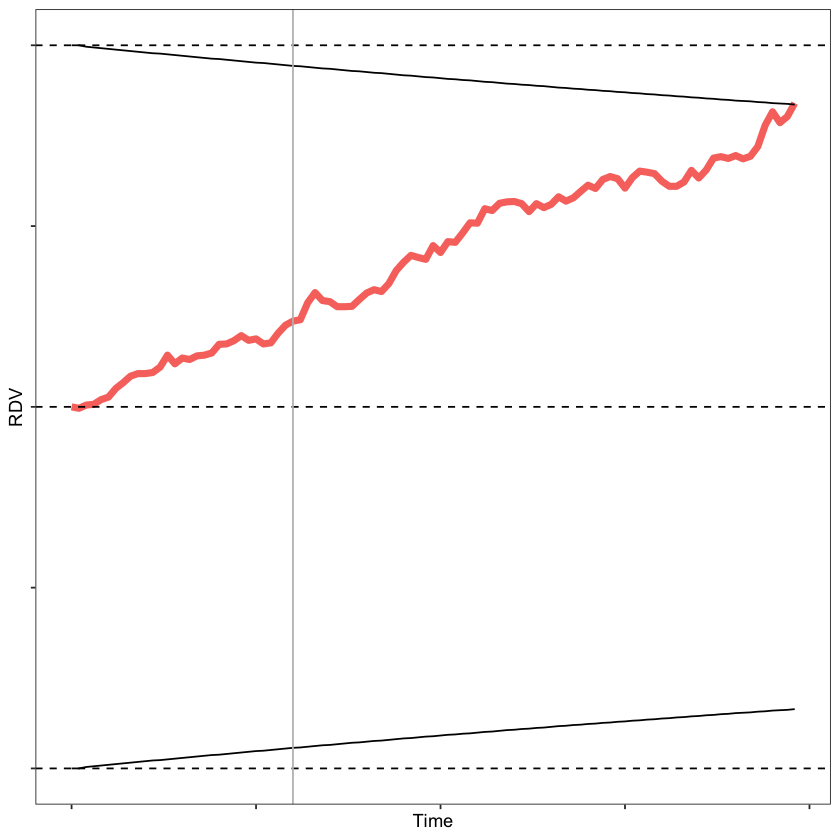

In [15]:
tmp$debug_df %>%
  ggplot()+
  geom_line(aes(time, RDV), color = "#F8766D", linewidth = 2) +
  geom_line(aes(time, barrier)) + 
  geom_line(aes(time, -barrier)) + 
  theme(panel.grid = element_blank(), 
        axis.text = element_blank(),
        axis.ticks = element_blank()) +
  geom_hline(aes(yintercept = 0), linetype = "dashed") +
  geom_hline(aes(yintercept = 1), linetype = "dashed") +
  geom_hline(aes(yintercept = -1), linetype = "dashed")+
  geom_vline(aes(xintercept = 30), color = "gray")+
  labs(x = "Time")

  # ggsave(file=paste0(fig_out_path, 'sampleCollapsingBounds.png'), height = 3, width=5, units="in")

# Test task simulation function

In [ ]:
source(paste0(helpers_path, '/ddm/sim_yn_ddm.R'))

In [ ]:
cur_d = .08
cur_sigma = .03
cur_nonDecisionTime = 200 #ms
cur_bias = 0
cur_barrierDecay = .008

sub_stims = data_yn_clean %>%
  filter((subnum == 611) & (day == 4) & (type == 1)) %>%
  filter(reference != -99) %>%
  filter(rt > .3 & rt < 2)

# names(sub_stims)

sim_trial_list = list("model1" = sim_trial)

tmp = sim_task(stimuli = sub_stims, model_name = "model1", sim_trial_list_ = sim_trial_list, d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, maxIter = 300, debug = T)

tmp



Are these reasonable parameter values?

In [ ]:
true_dat = sub_stims %>%
  ungroup() %>%
  select(yesChosen, rt) %>%
  mutate(rt = ifelse(yesChosen == 0, (-1) * rt, rt),
         data = "true")

sim_dat = tmp %>%
  select(choice, reactionTime) %>%
  mutate(yesChosen = ifelse(choice == "yes", 1, 0),
         rt = ifelse(choice == "yes", reactionTime, (-1) * reactionTime),
         data = "sim") %>%
  select(-choice, -reactionTime)

ggplot()+
  geom_histogram(data = true_dat, aes(rt, y = ..density..), bins = 30, alpha = 0.5)+
  geom_density(data = sim_dat, aes(rt))

# Test trial likelihood function

In [ ]:
source(paste0(helpers_path, '/ddm/yn_ddm.R'))

In [ ]:
i = 25

tmp[i,]

In [ ]:
fit_trial(d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, choice = tmp$choice[i], reactionTime = tmp$reactionTime[i], ValDiff = tmp$ValDiff[i], approxStateStep = .1)

In [ ]:
fit_trial(d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, choice = tmp$choice[i], reactionTime = tmp$reactionTime[i], ValDiff = tmp$ValDiff[i], approxStateStep = .01)

**Note higher (and incorrect!) parameter has higher likelihood with large state step size!**

In [ ]:
fit_trial(d = cur_d*10, sigma = cur_sigma*10, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, choice = tmp$choice[i], reactionTime = tmp$reactionTime[i], ValDiff = tmp$ValDiff[i], approxStateStep = .1)

In [ ]:
fit_trial(d = cur_d*10, sigma = cur_sigma*10, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, choice = tmp$choice[i], reactionTime = tmp$reactionTime[i], ValDiff = tmp$ValDiff[i], approxStateStep = .01)

In [ ]:
fit_trial(d = cur_d/2, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, choice = tmp$choice[i], reactionTime = tmp$reactionTime[i], ValDiff = tmp$ValDiff[i], approxStateStep = .01)

## Debugging state space

In [ ]:
source(paste0(helpers_path, '/ddm/yn_ddm.R'))

In [ ]:
tmp = sim_trial(d = .005, sigma = .07, nonDecisionTime = 200, bias = 0, barrierDecay = 0.001, ValDiff = -1, debug = T)

tmp$debug_df %>%
  ggplot()+
  geom_line(aes(time, RDV), color = "#F8766D", size = 2)+
  geom_line(aes(time, barrier))+
  geom_line(aes(time, -barrier))+
  theme(panel.grid = element_blank())+
  geom_hline(aes(yintercept = 0), linetype = "dashed")+
  geom_hline(aes(yintercept = 1), linetype = "dashed")+
  geom_hline(aes(yintercept = -1), linetype = "dashed")+
  labs(x = "Timestep (in 10 ms)")

In [ ]:
sim_trial_list = list("model1" = sim_trial)

tmp = sim_task(stimuli = tibble(normVDiff = rep(-1, 200)), model_name = "model1", sim_trial_list_ = sim_trial_list, d = .005, sigma = .07, nonDecisionTime = 200, bias = 0, barrierDecay = 0.001)

summary(tmp$reactionTime)

In [ ]:
debug_out = fit_trial(d = .005, sigma = .07, nonDecisionTime = 200, bias = 0, barrierDecay = 0, ValDiff = -1, choice = -1, reactionTime = 1.5, debug=T)

str(debug_out)

In [ ]:
annotations <- data.frame(
        xpos = c(-Inf),
        ypos =  c(Inf),
        annotateText = c(paste0("Choice: ", debug_out$likelihood$choice,
                         "\nRT: ", debug_out$likelihood$reactionTime,
                         "\nValDiff: ", debug_out$likelihood$ValDiff,
                         "\nd: ", debug_out$likelihood$d,
                         "\nsigma: ", debug_out$likelihood$sigma,
                         "\nndt: ", debug_out$likelihood$nonDecisionTime,
                         "\nlik: ", round(debug_out$likelihood$likelihood, 6))),
        hjustvar = c(-0.1) ,
        vjustvar = c(1.1))

tibble(probUpCrossing = debug_out$probUpCrossing,
       probDownCrossing = debug_out$probDownCrossing) %>%
  mutate(time = 1:n() * (debug_out$likelihood$timeStep)) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "likelihood", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))

In [ ]:
debug_out$renorm_debug %>%
  select(sumIn, cumSumPUp, cumSumPDown) %>%
  mutate(total = sumIn + cumSumPUp + cumSumPDown,
         time = 1:n() * debug_out$likelihood$timeStep) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "Cumulative prob", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))


What are these kinks in the distributions when there is decay in barriers?

In [ ]:
debug_out = fit_trial(d = .005, sigma = .07, nonDecisionTime = 200, bias = 0, barrierDecay = 0.001, ValDiff = -1, choice = -1, reactionTime = 1.5, debug=T)

annotations <- data.frame(
        xpos = c(-Inf),
        ypos =  c(Inf),
        annotateText = c(paste0("Choice: ", debug_out$likelihood$choice,
                         "\nRT: ", debug_out$likelihood$reactionTime,
                         "\nValDiff: ", debug_out$likelihood$ValDiff,
                         "\nd: ", debug_out$likelihood$d,
                         "\nsigma: ", debug_out$likelihood$sigma,
                         "\nndt: ", debug_out$likelihood$nonDecisionTime)),
        hjustvar = c(-0.1) ,
        vjustvar = c(1.1))

tibble(probUpCrossing = debug_out$probUpCrossing,
       probDownCrossing = debug_out$probDownCrossing) %>%
  mutate(time = 1:n() * (debug_out$likelihood$timeStep)) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "likelihood", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))

debug_out$renorm_debug %>%
  select(sumIn, cumSumPUp, cumSumPDown) %>%
  mutate(total = sumIn + cumSumPUp + cumSumPDown,
         time = 1:n() * debug_out$likelihood$timeStep) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "Cumulative prob", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))

In [ ]:
debug_out = fit_trial(d = .005, sigma = .07, nonDecisionTime = 200, bias = 0, barrierDecay = 0.001, ValDiff= -1, choice = -1, reactionTime = 3.5, debug=T)

annotations <- data.frame(
        xpos = c(-Inf),
        ypos =  c(Inf),
        annotateText = c(paste0("Choice: ", debug_out$likelihood$choice,
                         "\nRT: ", debug_out$likelihood$reactionTime,
                         "\nValDiff: ", debug_out$likelihood$ValDiff,
                         "\nd: ", debug_out$likelihood$d,
                         "\nsigma: ", debug_out$likelihood$sigma,
                         "\nndt: ", debug_out$likelihood$nonDecisionTime)),
        hjustvar = c(-0.1) ,
        vjustvar = c(1.1))

tibble(probUpCrossing = debug_out$probUpCrossing,
       probDownCrossing = debug_out$probDownCrossing) %>%
  mutate(time = 1:n() * (debug_out$likelihood$timeStep)) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "likelihood", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))

debug_out$renorm_debug %>%
  select(sumIn, cumSumPUp, cumSumPDown) %>%
  mutate(total = sumIn + cumSumPUp + cumSumPDown,
         time = 1:n() * debug_out$likelihood$timeStep) %>%
  gather(key, value, -time) %>%
  ggplot(aes(time, value))+
  geom_line( aes(color = key) )+
  labs(y = "Cumulative prob", color = "") +
  theme(legend.position = "bottom") +
  geom_text(data = annotations, aes(x = xpos, y = ypos, 
                                    hjust = hjustvar,
                                    vjust = vjustvar,
                                    label = annotateText))

# Test task fitting functions

In [ ]:
source(paste0(helpers_path, '/ddm/fit_yn_ddm.R'))

In [ ]:
cur_d = .03
cur_sigma = .02
cur_nonDecisionTime = 300 #ms
cur_bias = 0
cur_barrierDecay = .002

In [ ]:
sub_stims = data_yn_clean %>%
  filter((subnum == 611) & (day == 4) & (type == 1))

# names(sub_stims)

sim_trial_list = list("model1" = sim_trial)

tmp = sim_task(stimuli = sub_stims, model_name = "model1", sim_trial_list_ = sim_trial_list, d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, debug = T)

tmp

In [ ]:
fit_trial_list = list("model1" = fit_trial)

fit_task(data_ = tmp[1:100,], model_name_ = "model1", pars_ = list(d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay) , fit_trial_list_ = fit_trial_list, debug=FALSE)

Is negative log likelihood lower for the true parameter combination compared to other combinations?

In [ ]:
get_task_nll(data_ = tmp[1:100,], par_ = c(cur_d, cur_sigma, cur_nonDecisionTime, cur_bias, cur_barrierDecay), par_names_ = c("d", "sigma", "nonDecisionTime", "bias", "barrierDecay"), model_name_ = "model1")

In [ ]:
get_task_nll(data_ = tmp[1:100,], par_ = c(cur_d/2, cur_sigma, cur_nonDecisionTime, cur_bias, cur_barrierDecay), par_names_ = c("d", "sigma", "nonDecisionTime", "bias", "barrierDecay"), model_name_ = "model1")

In [ ]:
get_task_nll(data_ = tmp[1:100,], par_ = c(cur_d, cur_sigma/2, cur_nonDecisionTime, cur_bias, cur_barrierDecay), par_names_ = c("d", "sigma", "nonDecisionTime", "bias", "barrierDecay"), model_name_ = "model1")

## Test optim on simulated data

In [ ]:
cur_d = .03
cur_sigma = .02
cur_nonDecisionTime = 300 #ms
cur_bias = 0
cur_barrierDecay = .002

In [ ]:
sub_stims = data_yn_clean %>%
  filter((subnum == 611) & (day == 4) & (type == 1))

sim_trial_list = list("model1" = sim_trial)

tmp = sim_task(stimuli = sub_stims, model_name = "model1", sim_trial_list_ = sim_trial_list, d = cur_d, sigma = cur_sigma, nonDecisionTime = cur_nonDecisionTime, bias = cur_bias, barrierDecay = cur_barrierDecay, debug = T)

In [ ]:
start_vals = c(.01, .01, 100, 0, .001)
par_names = c("d", "sigma", "nonDecisionTime", "bias", "barrierDecay")
model = 'model1'

optim_out = optim(par = start_vals, get_task_nll, data_= tmp, par_names_ = par_names, model_name_ = model, control = list(maxit = 5, trace = 2))

cur_out = tibble(key = par_names, value = optim_out$par)
cur_out = cur_out %>% spread(key, value)
cur_out$nll = optim_out$value

cur_out

## Test optim on single subject

# Examine optim output for a single subject

Read in the estimates for a single subject:

In [ ]:
cur_sub = 601

all_files = list.files(path = paste0(here(), '/inputs/'), pattern= paste0("optim_YN_DDM_FIT_sub-",cur_sub))

optim_out= data.frame()

for (cur_file in all_files){
  cur_in = read.csv(paste0(here(), '/inputs/', cur_file))
  optim_out = rbind(optim_out, cur_in)
}

optim_out

Distribution of estimates

In [ ]:
optim_out %>%
  select(d, sigma, nonDecisionTime, bias, barrierDecay) %>%
  gather(key, value) %>%
  ggplot(aes(value, fill = key))+
  geom_histogram(bins = 30, alpha = .5)+
  facet_wrap(~key, scales = "free")+
  theme(legend.position = "none",
        panel.grid = element_blank())

In [ ]:
p = optim_out %>%
  select(d, sigma, nonDecisionTime, bias, barrierDecay, day, type) %>%
  gather(key, value, -day, -type) %>%
  group_by(key, day, type) %>%
  summarise(mean_par = mean(value), 
            sem_par = sd(value)/sqrt(n()), .groups = "keep") %>%
  mutate(type = ifelse(type == 1, "HT", "RE"),
         key = factor(key, levels = c("d", "sigma", "nonDecisionTime", "bias", "barrierDecay"))) %>%
  ggplot(aes(day, mean_par, color = type))+
  geom_point(position = position_dodge(width=.5))+
  geom_errorbar(aes(ymin = mean_par - sem_par, ymax = mean_par + sem_par), width = .1, position = position_dodge(width=.5)) +
  facet_wrap(~key, scales = "free", ncol = 5) +
  theme(legend.position = "bottom",
        panel.grid.minor = element_blank())+
  scale_color_brewer(palette = "Dark2")+
  labs(y = "", color = "")+
  scale_x_continuous(breaks = seq(1:11))

ggsave(file=paste0(fig_out_path, 'yn_sub-',cur_sub,'_optimDDMparsOverDays.jpg'), p, height = 4, width=12, units="in")


Correlation between estimates

In [ ]:
# Average correlation across days of HT

cor_mats = list()
for(cur_day in c(1:11)){
  cor_dt = optim_out %>%
    filter((type == 1) & (day == cur_day)) %>%
    select(d, sigma, nonDecisionTime, bias, barrierDecay)
  
  cor_mats[[cur_day]] = cor(cor_dt)
  
  
}

mean_cor_mat = Reduce("+", cor_mats) / length(cor_mats)
tg = tableGrob(round(mean_cor_mat, 3) )
ggsave(paste0(fig_out_path, "sub-",cur_sub, "_ddmOptimHTparCors.jpg"), tg, width = 12, height = 4)

In [ ]:
# Average correlation across days of HT

cor_mats = list()
for(cur_day in c(1:11)){
  cor_dt = optim_out %>%
    filter((type == 0) & (day == cur_day)) %>%
    select(d, sigma, nonDecisionTime, bias, barrierDecay)
  
  cor_mats[[cur_day]] = cor(cor_dt)
  
  
}

mean_cor_mat = Reduce("+", cor_mats) / length(cor_mats)
tg = tableGrob(round(mean_cor_mat, 3) )
ggsave(paste0(fig_out_path, "sub-",cur_sub, "_ddmOptimREparCors.jpg"), tg, width = 12, height = 4)

Correlation between each parameter and its starting point

In [ ]:
optim_out %>%
  ggplot(aes(start_d, d))+
  geom_point(size = 1)

optim_out %>%
  ggplot(aes(start_sigma, sigma))+
  geom_point(size = 1)

optim_out %>%
  ggplot(aes(start_nonDecisionTime, nonDecisionTime))+
  geom_point(size = 1)

optim_out %>%
  ggplot(aes(start_bias, bias))+
  geom_point(size = 1)

optim_out %>%
  ggplot(aes(start_barrierDecay, barrierDecay))+
  geom_point(size = 1)

In [ ]:
optim_out %>%
  select(d, start_d)

optim_out %>%
  select(sigma, start_sigma)

optim_out %>%
  select(nonDecisionTime, start_nonDecisionTime)

optim_out %>%
  select(bias, start_bias)

optim_out %>%
  select(barrierDecay, start_barrierDecay)

In [ ]:
optim_out %>%
  mutate(diff_d = abs(d - start_d),
         diff_sigma = abs(sigma - start_sigma),
         diff_bias = abs(bias - start_bias),
         diff_nonDecisionTime = abs(nonDecisionTime - start_nonDecisionTime),
         diff_barrierDecay = abs(barrierDecay - start_barrierDecay)) %>%
  select(diff_d, diff_sigma, diff_bias, diff_nonDecisionTime, diff_barrierDecay) %>%
  gather(key, value) %>%
  select(value) %>%
  distinct()

Posterior predictive data

In [ ]:
source(paste0(helpers_path, '/ddm/yn_ddm.R'))

Checks of stylized behavioral effects